<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем необходимые библиотеки, модели, метрики:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Рассмотрим данные:

In [2]:
original_data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])

In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
original_data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
original_data.duplicated().sum()

0

In [6]:
original_data.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
original_data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Дубликаты и пропуски отсутствуют. Необходимо привести данные к нижнему регистру. Рассмотрим также  целевой признак.

In [8]:
data = pd.DataFrame(original_data)

In [9]:
data['text'] = data['text'].str.lower()

In [10]:
data.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

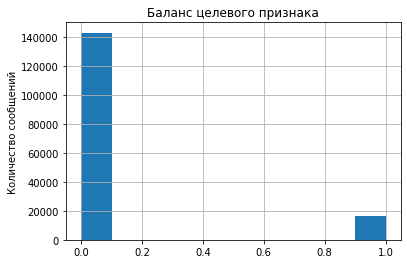

In [11]:
data['toxic'].hist()
plt.title('Баланс целевого признака')
plt.ylabel('Количество сообщений')

plt.show()

Наблюдается сильный дисбаланс целевого признака, необходимо учесть в дальнейшем. Напишем функцию для лемматизации. Язык текста - английский.   


<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> Верно!

In [12]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    clean = " ".join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
    word_list = nltk.word_tokenize(clean)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])    
    return lemmatized_output


<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Есть лемматизация и очистка
    
https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/ - интересная статья по лемматизаторам

Применим функцию с столбцу с комментариями. 

In [13]:
data['text'] = data['text'].apply(clean_text)

In [14]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestion on impro...,0
4,you sir are my hero any chance you remember wh...,0


Построим мешок слов, чтобы определить характерные слова для каждого класса (токсичные и нетоксичные). Чтобы почистить мешок, нужно найти топ слова. Также посмотрим на наиболее употребимые.

Начнем с токсичных.

In [15]:
stop_words = set(nltk_stopwords.words('english'))

In [16]:
toxic_lem = data[data['toxic'] ==1]
corpus = list(toxic_lem['text'])
count_vect = CountVectorizer(max_features=20, stop_words=stop_words)
bow = count_vect.fit_transform(corpus)

In [17]:
count_vect.get_feature_names() 

['article',
 'bitch',
 'die',
 'faggot',
 'fat',
 'fuck',
 'fucking',
 'gay',
 'get',
 'go',
 'hate',
 'know',
 'like',
 'nigger',
 'page',
 'people',
 'shit',
 'suck',
 'wa',
 'wikipedia']

Аналогично сделаем для нетоксичных:

In [18]:
nontoxic_lem = data[data['toxic'] == 0]
corpus = list(nontoxic_lem['text'])
count_vect = CountVectorizer(max_features=20, stop_words=stop_words)
bow = count_vect.fit_transform(corpus)

In [19]:
count_vect.get_feature_names() 

['also',
 'article',
 'edit',
 'ha',
 'know',
 'like',
 'one',
 'page',
 'people',
 'please',
 'see',
 'source',
 'talk',
 'think',
 'time',
 'use',
 'user',
 'wa',
 'wikipedia',
 'would']

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Интересный анализ!

Советую попробовать [LDA](https://habr.com/ru/post/417167/)

Данные показатели постараемся учесть в дальнейшем для анализа данных и создания признаков. 

Разобьем выборку по отношению 60/20/20. Выделим признаки:

In [20]:
features = data['text']
target = data['toxic']

In [21]:
features_df, features_test, target_df, target_test = train_test_split(
    features, target, test_size=.4, random_state=12345, stratify= target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_df, target_df, test_size=.5, random_state=12345, stratify= target_df)

In [22]:
print(features_test.shape)
print(features_train.shape)
print(features_valid.shape)

print(target_test.shape)
print(target_train.shape)
print(target_valid.shape)

(63717,)
(47787,)
(47788,)
(63717,)
(47787,)
(47788,)


In [23]:
print(target_train.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')
print(target_valid.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')
print(target_test.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')

0    89.8%
1    10.2%
Name: toxic, dtype: object
0    89.8%
1    10.2%
Name: toxic, dtype: object
0    89.8%
1    10.2%
Name: toxic, dtype: object


Переведем слова в векторы и посчитаем tf_idf:

In [24]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [26]:
train_tf_idf = count_tf_idf.fit_transform(features_train)
valid_tf_idf = count_tf_idf.transform(features_valid)
test_tf_idf = count_tf_idf.transform(features_test)

In [27]:
print('Размер матрицы:', train_tf_idf.shape)
print('Размер матрицы:', valid_tf_idf.shape)
print('Размер матрицы:', test_tf_idf.shape)

Размер матрицы: (47787, 79135)
Размер матрицы: (47788, 79135)
Размер матрицы: (63717, 79135)


<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Нет утечки тестовых данных!

**Вывод:**
1. Изучили данные, проверили данные на наличие пропусков, дубликатов. Исправлен регистр;
2. Очистили данные, лемматизировали данные в столбце text;
3. Построили мешок слов по классам, показали наиболее употребляемые для каждого класса;
4. Получили признаки, а также разбили данные на обучающую, валидационную и тестовую выборки;
5. Отметили наличие бисбаланса классов в целевом признаки; 
6. Необходимо решить задачу классификации.

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Промежуточный вывод верно описывает проделанную работу

## Обучение

Начнем обучение с **LogisticRegression:**

In [28]:
%%time

best_result = 7.5
results = []

for c in range(1, 10):
    model = LogisticRegression(class_weight='balanced', 
                          random_state=12345, 
                          max_iter=1000, 
                          solver='lbfgs', 
                               C=c)
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    
    print ('Значение С равно:', c)
    print('Значение F1_score равно:', f1_score(target_valid, predicted_valid))
print()  

Значение С равно: 1
Значение F1_score равно: 0.7385014836795253
Значение С равно: 2
Значение F1_score равно: 0.7470588235294118
Значение С равно: 3
Значение F1_score равно: 0.7508879715849093
Значение С равно: 4
Значение F1_score равно: 0.7524483661398236
Значение С равно: 5
Значение F1_score равно: 0.7545880515423663
Значение С равно: 6
Значение F1_score равно: 0.7562364957768613
Значение С равно: 7
Значение F1_score равно: 0.7555205047318612
Значение С равно: 8
Значение F1_score равно: 0.7560830860534125
Значение С равно: 9
Значение F1_score равно: 0.7556525188417295

CPU times: user 2min 22s, sys: 3min 13s, total: 5min 35s
Wall time: 5min 36s


Для LogisticRegression лучший F1 равен 0.756 при C = 6

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Круто, что ты используешь валидационную выборку для предотвращения утечки тестовых данных

Для **DecisionTreeClassifier**:

In [29]:
%%time

best_result = 0.1
depth = 0
depths = []
results = []

for depth in range(30, 50, 5):
    model = DecisionTreeClassifier(random_state=12345, 
                                  max_depth=depth,
                                  class_weight='balanced')
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    result = f1_score(target_valid, predicted_valid)
    depths.append(depth)
    results.append(result)
                
    if result > best_result:
        best_depth = depth
        best_result = result

        
print('Значение F1_score равно:', best_result, '   Глубина:', best_depth)   

Значение F1_score равно: 0.6338441473752853    Глубина: 45
CPU times: user 43.8 s, sys: 128 ms, total: 43.9 s
Wall time: 44.1 s


Для **RandomForestClassifier:**

In [30]:
 %%time
    
best_result = 0.1
depth = 0
depths = []
results = []
    
for depth in range(3, 20, 2):
    model = RandomForestClassifier(random_state=12345, 
                                   max_depth = depth, 
                                   class_weight='balanced')
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    result = f1_score(target_valid, predicted_valid)
    depths.append(depth)
    results.append(result)
                
    if result > best_result:
        best_depth = depth
        best_result = result

        
print('Значение F1_score равно:', best_result, '   Глубина:', best_depth)   

Значение F1_score равно: 0.40621804049907956    Глубина: 19
CPU times: user 25 s, sys: 119 ms, total: 25.2 s
Wall time: 25.3 s


Лучшее количество деревьев:

In [31]:
%%time

best_result = 0.4
est = 0
ests = []
results = []

for est in [100, 500, 1000]:
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=est, 
                                   max_depth=19,
                                   class_weight='balanced')
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    result = f1_score(target_valid, predicted_valid)
    depths.append(depth)
    results.append(result)
                
    if result > best_result:
        best_est = est
        best_result = result

print('Значение F1_score равно:', best_result, '   Количество деревьев:', best_est)  

Значение F1_score равно: 0.4355628058727569    Количество деревьев: 500
CPU times: user 1min 11s, sys: 287 ms, total: 1min 12s
Wall time: 1min 12s


Для **CatBoostClassifier:**

In [32]:
%%time

model = CatBoostClassifier(eval_metric = 'F1', random_state=12345, iterations=100)
model.fit(train_tf_idf, target_train)
predicted_valid = model.predict(valid_tf_idf)

print('Значение F1_score равно:', f1_score(target_valid, predicted_valid))

Learning rate set to 0.443608
0:	learn: 0.4121447	total: 1.56s	remaining: 2m 35s
1:	learn: 0.5276583	total: 2.63s	remaining: 2m 8s
2:	learn: 0.4716893	total: 3.72s	remaining: 2m
3:	learn: 0.5539620	total: 5s	remaining: 2m
4:	learn: 0.5585507	total: 6.09s	remaining: 1m 55s
5:	learn: 0.5790900	total: 7.18s	remaining: 1m 52s
6:	learn: 0.5930840	total: 8.24s	remaining: 1m 49s
7:	learn: 0.6132889	total: 9.28s	remaining: 1m 46s
8:	learn: 0.6148508	total: 10.3s	remaining: 1m 44s
9:	learn: 0.6347518	total: 11.3s	remaining: 1m 42s
10:	learn: 0.6322986	total: 12.4s	remaining: 1m 40s
11:	learn: 0.6356568	total: 13.4s	remaining: 1m 38s
12:	learn: 0.6454398	total: 14.4s	remaining: 1m 36s
13:	learn: 0.6486559	total: 15.5s	remaining: 1m 35s
14:	learn: 0.6515558	total: 16.5s	remaining: 1m 33s
15:	learn: 0.6567842	total: 17.5s	remaining: 1m 31s
16:	learn: 0.6589457	total: 18.4s	remaining: 1m 30s
17:	learn: 0.6661365	total: 19.5s	remaining: 1m 28s
18:	learn: 0.6687797	total: 20.5s	remaining: 1m 27s
19:	

**Итого:** Лучшие показатель у LogisticRegression F1 = 0.756 при C = 6, ее и будем тестировать.

Объеденим тренировочную и валидационную выборки, 

In [35]:
model = LogisticRegression(class_weight='balanced', 
                          random_state=12345, 
                          max_iter=1000, 
                          solver='lbfgs',
                          C=6)

features_train_lr = pd.concat([features_train, features_valid])
target_train_lr = pd.concat([target_train, target_valid])
features_train_tf_idf = count_tf_idf.fit_transform(features_train_lr)
features_test_tf_idf = count_tf_idf.transform(features_test)

model.fit(features_train_tf_idf, target_train_lr)
predicted_test = model.predict(features_test_tf_idf)


print('Значение F1_score равно:', f1_score(target_test, predicted_test))

F1_score: 0.7576997630842128


<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Порог пройден!

## Выводы

1. В ходе исследования были загружены и изучены данные, проводена их предобработка;
3. Для исследования данные были разбиты на три выборки;
4. Для обучения были использованы модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, CatBoostClassifier. Лучшие показатели F1_score у LogisticRegression;
5. Модель LogisticRegression на итоговой тестовой выборке показала хороший результат F1_score = 0.757, что соответствует поставленному условию;
6. Для дальнейшего использования рекомендована модель LogisticRegression.

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Отлично! Работа завершена успешно!